<a href="https://colab.research.google.com/github/ThierrryScotto/Air-Passengers-2.0/blob/main/Air_Passengers_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [1]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import datetime
import prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import sem
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Getting the data

In [3]:
url = "https://raw.githubusercontent.com/ThierrryScotto/Air-Passengers-2.0/main/AirPassengers.csv"

dataset = pd.read_csv(url)
dataset

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


# Data Preparation

In [4]:
def plot_dataset(x, y, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [5]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [6]:
dataset.columns

Index(['Month', '#Passengers'], dtype='object')

In [7]:
dataset.shape

(144, 2)

In [8]:
dataset = dataset.rename(columns={"#Passengers": "Passengers"})

In [9]:
dataset['Month'].astype

<bound method NDFrame.astype of 0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: Month, Length: 144, dtype: object>

In [10]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset['Month']

0     1949-01-01
1     1949-02-01
2     1949-03-01
3     1949-04-01
4     1949-05-01
         ...    
139   1960-08-01
140   1960-09-01
141   1960-10-01
142   1960-11-01
143   1960-12-01
Name: Month, Length: 144, dtype: datetime64[ns]

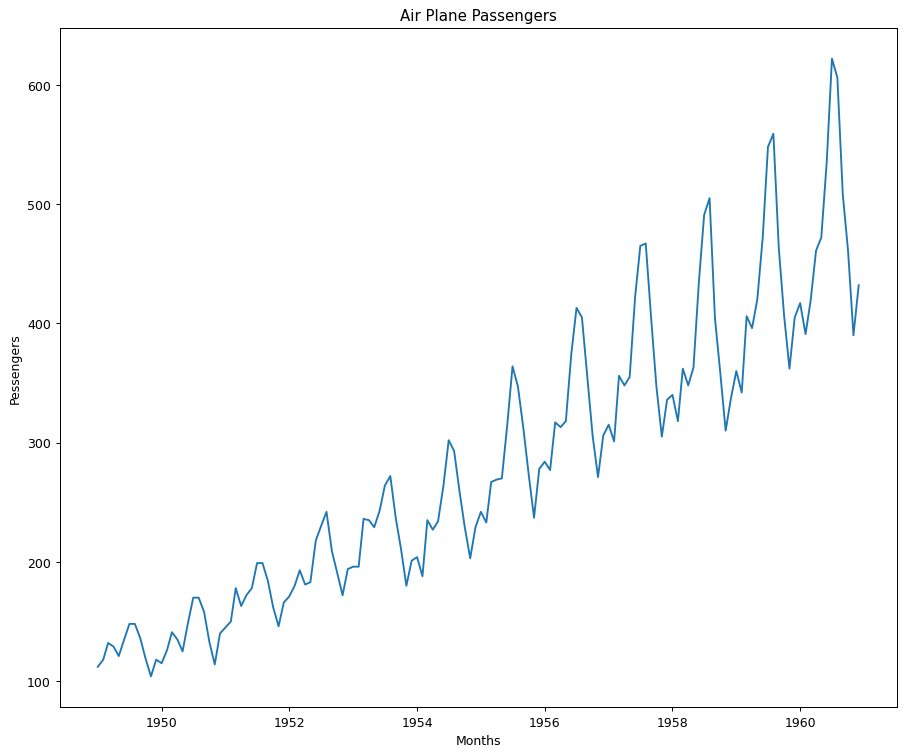

In [11]:
plot_dataset(dataset['Month'], dataset['Passengers'], "Months", "Pessengers", 'Air Plane Passengers')

In [12]:
dataset['Passengers'].head(5)

0    112
1    118
2    132
3    129
4    121
Name: Passengers, dtype: int64

In [13]:
dataset.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [14]:
dataset.isnull().sum()

Month         0
Passengers    0
dtype: int64

set index

In [15]:
dataset = dataset.set_index("Month")
dataset = dataset.sort_index()
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Checking the SE

In [16]:
sem(np.array(dataset['Passengers']))

9.997193078578599

#### Checking if Gaussian distribution makes sense

<AxesSubplot:>

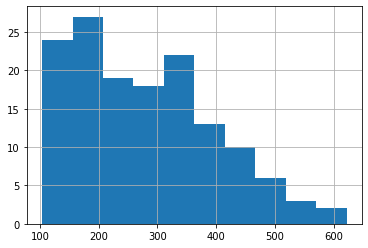

In [17]:
dataset['Passengers'].hist()

# Time Series analysis

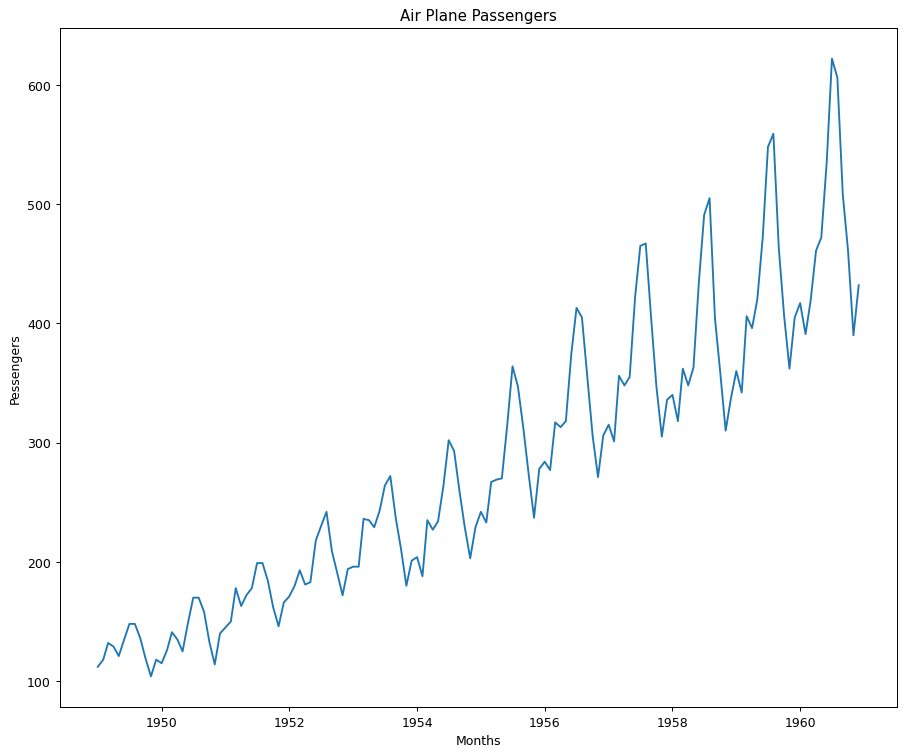

In [18]:
plot_dataset(dataset.index, dataset['Passengers'], "Months", "Pessengers", 'Air Plane Passengers')

## Decomposition

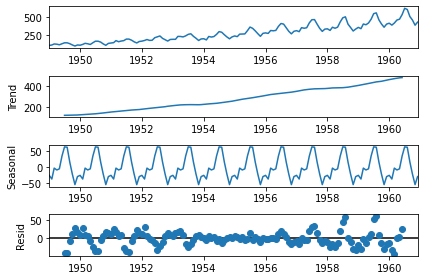

In [19]:
result = seasonal_decompose(dataset, model='additive', period=12)
result.plot()
plt.show()

### Trend

<AxesSubplot:xlabel='Month'>

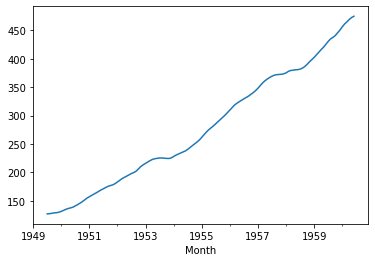

In [20]:
result.trend.plot()

### Sesanality

<AxesSubplot:xlabel='Month'>

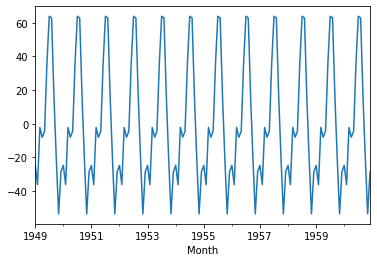

In [21]:
result.seasonal.plot()

### Residual

<AxesSubplot:xlabel='Month'>

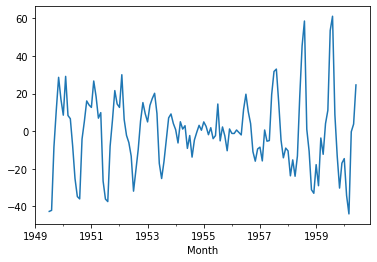

In [22]:
residual = result.resid
residual.plot()

### De-trended

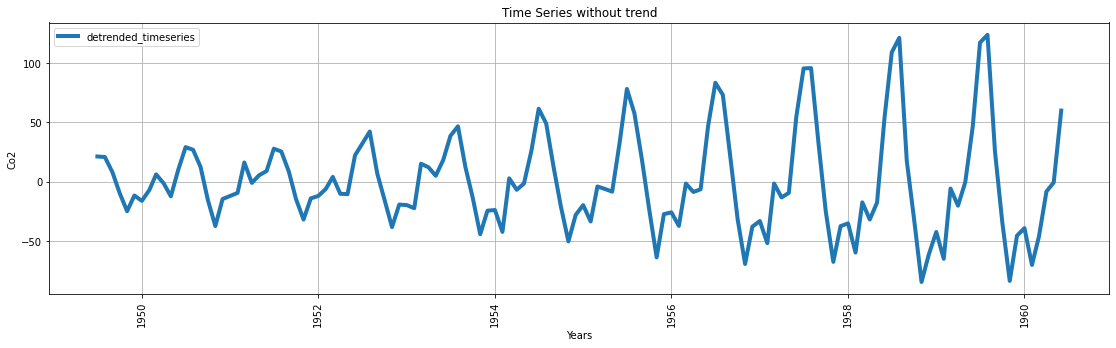

In [23]:
de_trended = dataset['Passengers'] - result.trend

plt.figure(figsize=(19,5))
plt.grid()
plt.plot(dataset.index, de_trended, marker='', linestyle='-', label='detrended_timeseries', linewidth=4)
plt.title("Time Series without trend")
plt.xlabel("Years")
plt.ylabel("Co2")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### De-seasonalised

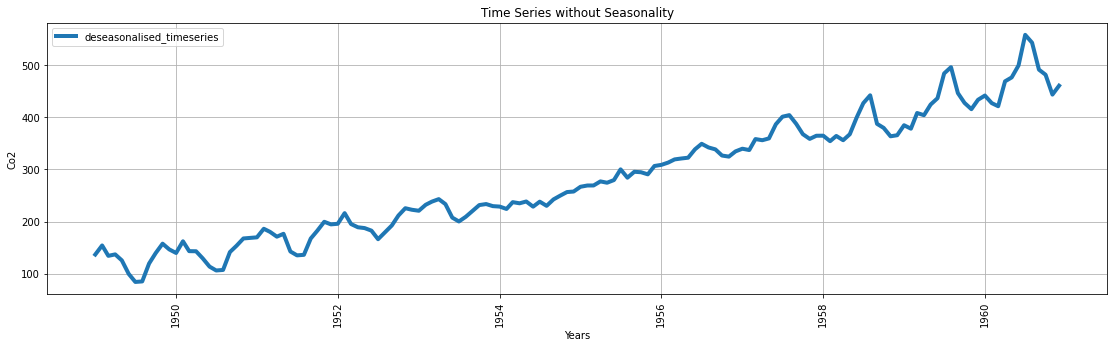

In [24]:
dataset_de_seasonalised = dataset['Passengers'] - result.seasonal

plt.figure(figsize=(19,5))
plt.grid()
plt.plot(dataset.index, dataset_de_seasonalised, marker='', linestyle='-', label='deseasonalised_timeseries', linewidth=4)
plt.title("Time Series without Seasonality")
plt.xlabel("Years")
plt.ylabel("Co2")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Residual

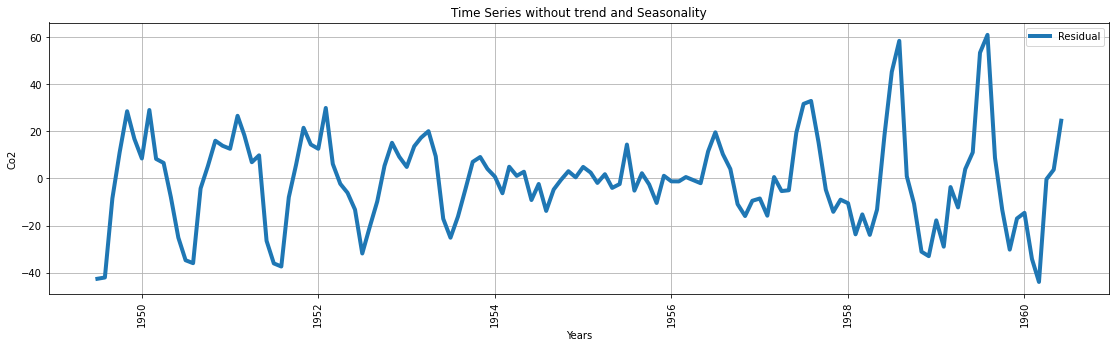

In [25]:
dataset_residuals = dataset['Passengers'] - result.trend - result.seasonal

plt.figure(figsize=(19,5))
plt.grid()
plt.plot(dataset.index, dataset_residuals, marker='', linestyle='-', label='Residual', linewidth=4)
plt.title("Time Series without trend and Seasonality")
plt.xlabel("Years")
plt.ylabel("Co2")
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Finding out if my series is stationary

### Separating the time series into two groups and calculating the mean and variance of each.

In [26]:
def mean_variance(df):
  middle =  int(len(df) / 2)

  part_1, part_2 = df.head(middle), df.tail(middle)
  mean1, mean2 = part_1.mean(), part_2.mean()
  var1, var2 = part_1.var(), part_2.var()
  print('\n-- MEAN and VARIANCE --')
  print('Average of set 1: %f, Average of set 2: %f' % (mean1, mean2))
  print('variance of set 1: %f, Variance of set 2: %f\n' % (var1, var2))

In [27]:
mean_variance(dataset)


-- MEAN and VARIANCE --
Average of set 1: 182.902778, Average of set 2: 377.694444
variance of set 1: 2275.694640, Variance of set 2: 7471.736307



### Dickey–Fuller test

In [28]:
def check_stationarity(df):
  result = adfuller(df, autolag='AIC')

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
  print('\n\n')

In [29]:
check_stationarity(dataset)

-- Dickey–Fuller test --
ADF Statistic: 0.815369
p-value: 0.991880
Critical values: 
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770





### Autocorrelation

In [30]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

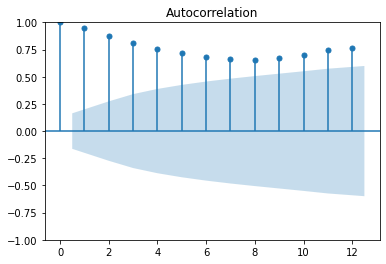

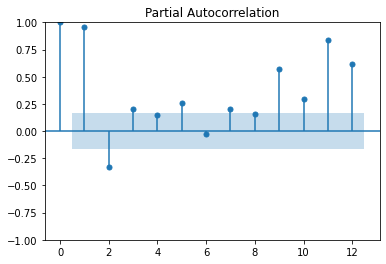

In [31]:
plot_autocorrelation(dataset, lags=12)

### Converting series to stationary

#### Log transformation

In [32]:
dataset_log = np.log(dataset)
dataset_log = dataset_log.diff().dropna()


-- MEAN and VARIANCE --
Average of set 1: 0.010074, Average of set 2: 0.008162
variance of set 1: 0.010693, Variance of set 2: 0.012308

-- Dickey–Fuller test --
ADF Statistic: -2.717131
p-value: 0.071121
Critical values: 
	1%: -3.482501
	5%: -2.884398
	10%: -2.578960





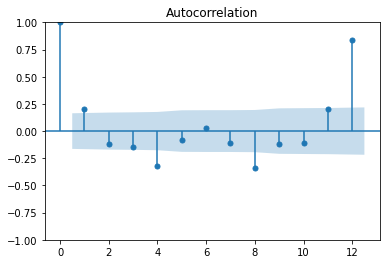

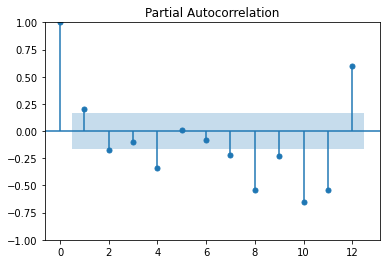

In [33]:
mean_variance(dataset_log)
check_stationarity(dataset_log)
plot_autocorrelation(dataset_log, lags=12)

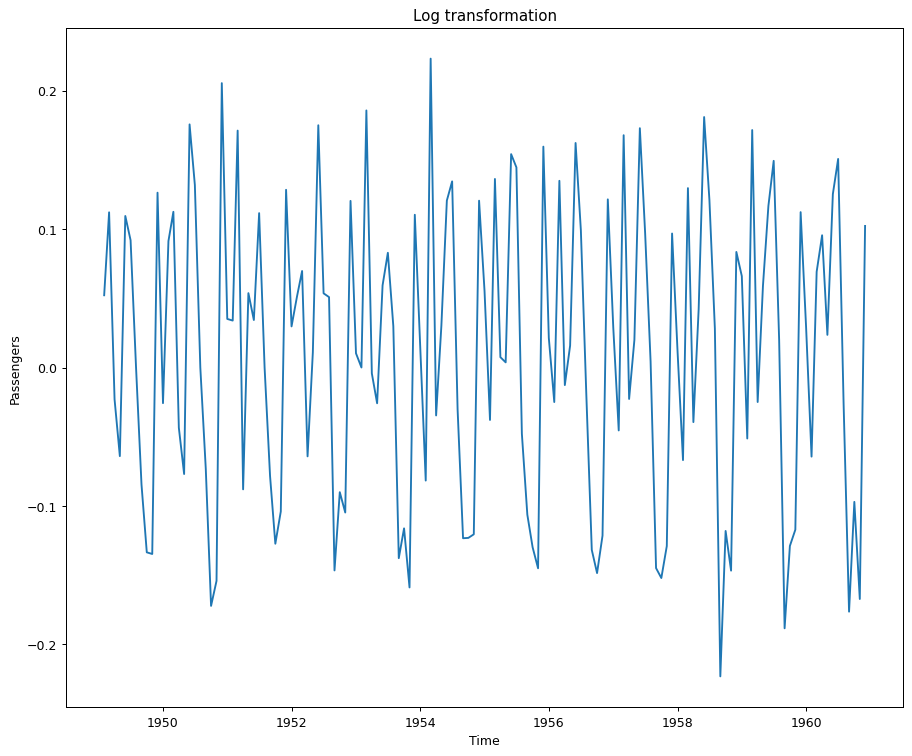

In [34]:
plot_dataset(dataset_log.index, dataset_log, 'Time', 'Passengers', "Log transformation")

#### Seasonal Difference

In [35]:
dataset_seasonal_difference = dataset['Passengers'] - dataset['Passengers'].shift(12)
dataset_seasonal_difference = dataset_seasonal_difference.dropna()
dataset_seasonal_difference

Month
1950-01-01     3.0
1950-02-01     8.0
1950-03-01     9.0
1950-04-01     6.0
1950-05-01     4.0
              ... 
1960-08-01    47.0
1960-09-01    45.0
1960-10-01    54.0
1960-11-01    28.0
1960-12-01    27.0
Name: Passengers, Length: 132, dtype: float64


-- MEAN and VARIANCE --
Average of set 1: 24.106061, Average of set 2: 39.439394
variance of set 1: 184.619347, Variance of set 2: 324.188578

-- Dickey–Fuller test --
ADF Statistic: -3.383021
p-value: 0.011551
Critical values: 
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770





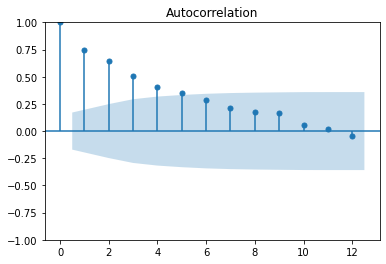

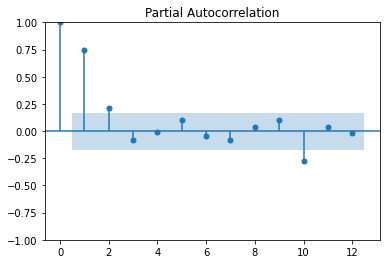

In [36]:
mean_variance(dataset_seasonal_difference)
check_stationarity(dataset_seasonal_difference)
plot_autocorrelation(dataset_seasonal_difference, lags=12)

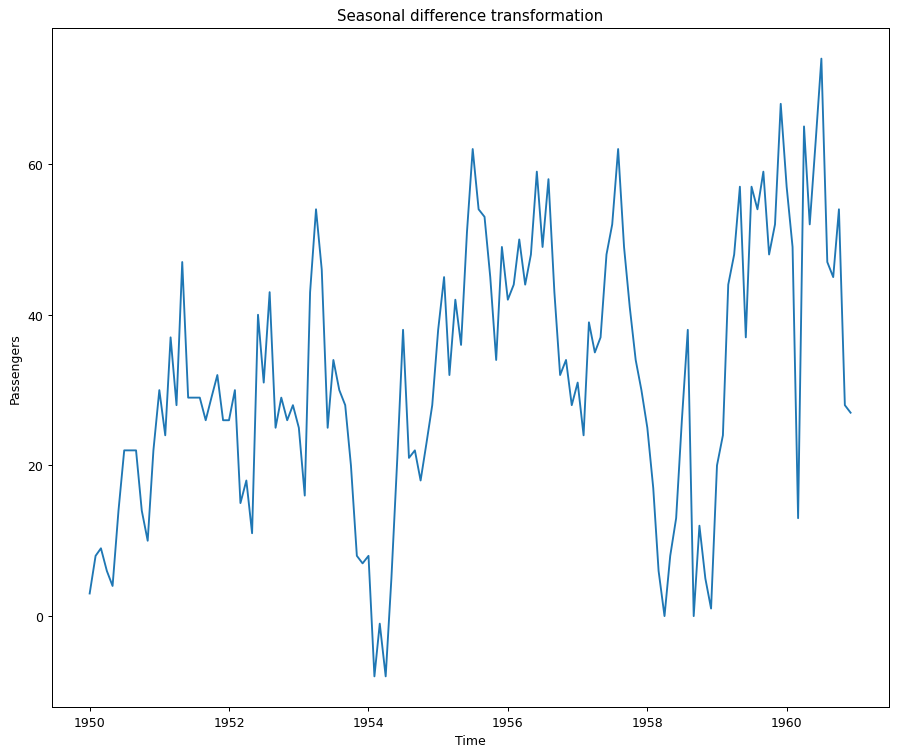

In [37]:
plot_dataset(dataset_seasonal_difference.index, dataset_seasonal_difference, 'Time', 'Passengers', "Seasonal difference transformation")

#### Diference

In [38]:
dataset_difference = dataset['Passengers'] - dataset['Passengers'].shift(1)
dataset_difference = dataset_difference.diff().dropna()
dataset_difference

Month
1949-03-01      8.0
1949-04-01    -17.0
1949-05-01     -5.0
1949-06-01     22.0
1949-07-01     -1.0
              ...  
1960-08-01   -103.0
1960-09-01    -82.0
1960-10-01     51.0
1960-11-01    -24.0
1960-12-01    113.0
Name: Passengers, Length: 142, dtype: float64


-- MEAN and VARIANCE --
Average of set 1: 0.098592, Average of set 2: 0.408451
variance of set 1: 607.290141, Variance of set 2: 2592.302213

-- Dickey–Fuller test --
ADF Statistic: -16.384232
p-value: 0.000000
Critical values: 
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770





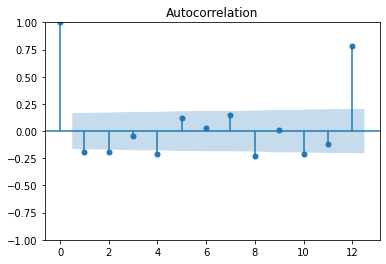

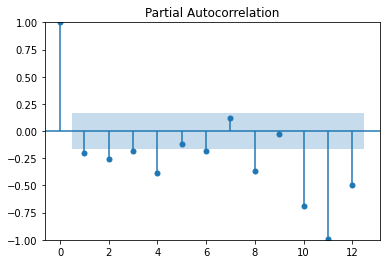

In [39]:
mean_variance(dataset_difference)
check_stationarity(dataset_difference)
plot_autocorrelation(dataset_difference, lags=12)

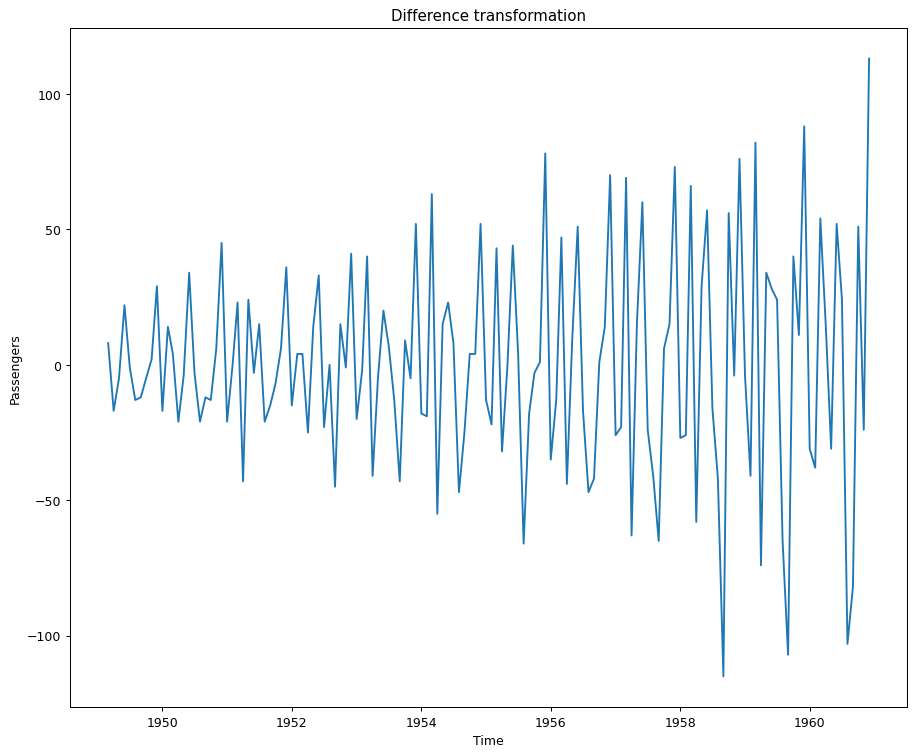

In [40]:
plot_dataset(dataset_difference.index, dataset_difference, 'Time', 'Passengers', "Difference transformation")

#### Taking the square root of the data

In [41]:
dataset_sqrt = np.sqrt(dataset)
dataset_sqrt = dataset_sqrt.diff().dropna()
dataset_sqrt

,Passengers
Month,
1949-02-01,0.279775
1949-03-01,0.626345
1949-04-01,-0.131309
1949-05-01,-0.357817
1949-06-01,0.618950
...,...
1960-08-01,-0.322861
1960-09-01,-2.078212
1960-10-01,-1.067945



-- MEAN and VARIANCE --
Average of set 1: 0.064081, Average of set 2: 0.073637
variance of set 1: 0.481244, Variance of set 2: 1.193317

-- Dickey–Fuller test --
ADF Statistic: -3.186422
p-value: 0.020784
Critical values: 
	1%: -3.481682
	5%: -2.884042
	10%: -2.578770





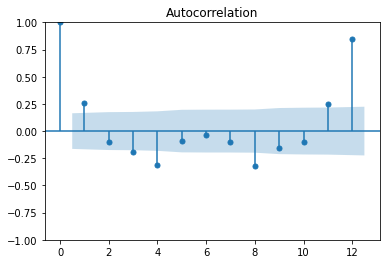

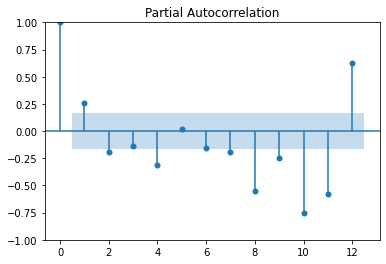

In [42]:
mean_variance(dataset_sqrt)
check_stationarity(dataset_sqrt)
plot_autocorrelation(dataset_sqrt, lags=12)

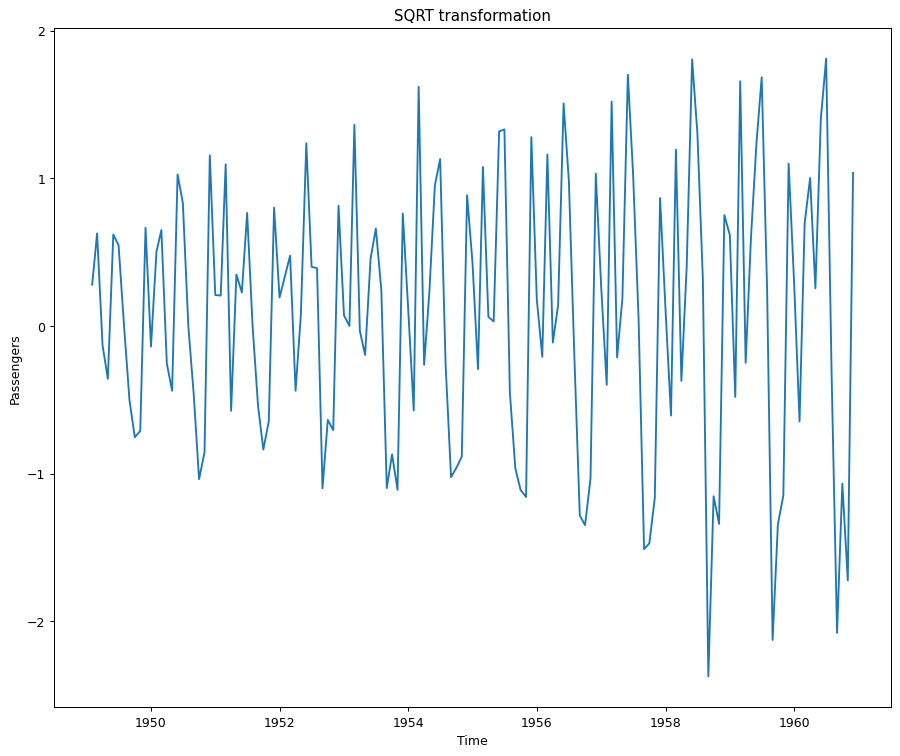

In [43]:
plot_dataset(dataset_sqrt.index, dataset_sqrt, 'Time', 'Passengers', "SQRT transformation")

## Training the model

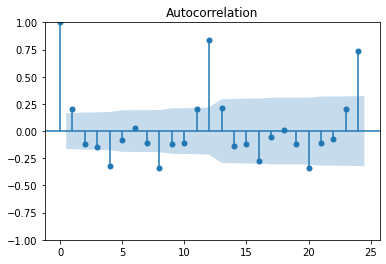

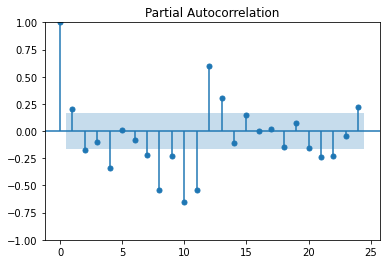

In [44]:
plot_autocorrelation(dataset_log, lags=24)

### Functions

In [45]:
def plot_forecast(df_one, df_two, legend_one, legend_two, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.scatter(df_one.index, df_one['co2'])
  plt.plot(df_two.index, df_two['co2'], 'red')
  plt.legend([legend_one, legend_two])
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

### Splitting data

In [46]:
dataset_log

,Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [47]:
FORECAST_SIZE = 12
df_train = dataset_log.iloc[:-FORECAST_SIZE]
df_test = dataset_log.iloc[-FORECAST_SIZE:]

### Prophet

In [48]:
from prophet import Prophet

In [49]:
ts = pd.DataFrame({'ds': df_train.index, 'y': df_train['Passengers']})

In [50]:
prophet = Prophet()
prophet.fit(ts)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8rjttngh/mcp82nrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8rjttngh/t5a3cane.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16942', 'data', 'file=/tmp/tmp8rjttngh/mcp82nrz.json', 'init=/tmp/tmp8rjttngh/t5a3cane.json', 'output', 'file=/tmp/tmp8rjttngh/prophet_modelgi7q9jmg/prophet_model-20230316005332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:53:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:53:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Forecasted data

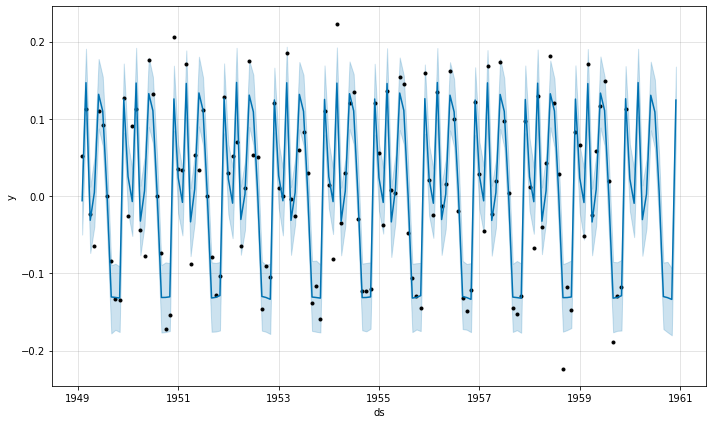

In [51]:
future   = prophet.make_future_dataframe(periods=FORECAST_SIZE, freq='MS', include_history=True)
forecast = prophet.predict(future)

prophet.plot(forecast)
plt.show()

#### Origin data vs forecasted data

Text(0.5, 1.0, 'Forecast Prothet')

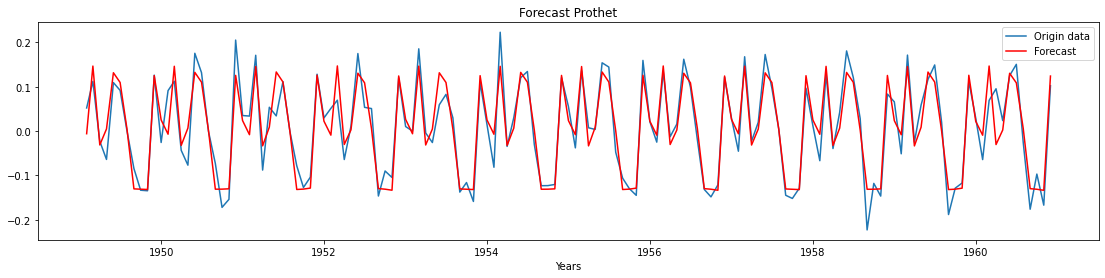

In [52]:
plt.figure(figsize=(19, 4))
plt.plot(dataset_log.index, dataset_log['Passengers'])
plt.plot(forecast['ds'], forecast['yhat'], 'red')
plt.legend(["Origin data", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast Prothet")

#### Origin test data vs forecasted test data

Text(0.5, 1.0, 'Forecast Prothet - Test')

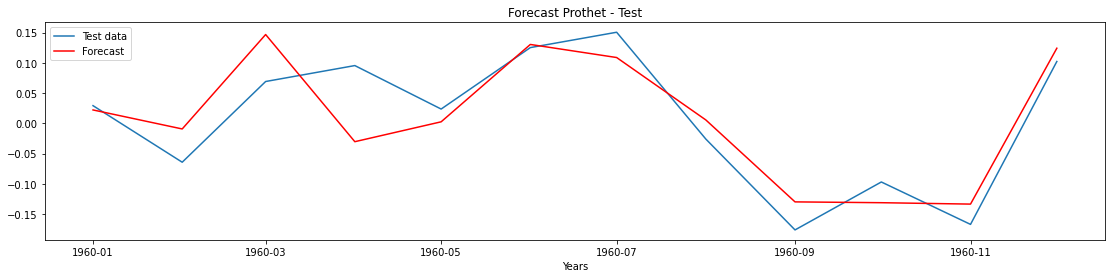

In [53]:
forecast_test = forecast.iloc[-FORECAST_SIZE:]

plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['Passengers'])
plt.plot(forecast_test['ds'], forecast_test['yhat'], 'red')
plt.legend(["Test data", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast Prothet - Test")

#### Components

In [54]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1949-02-01,-0.005950,-0.049765,0.039434
1,1949-03-01,0.146761,0.100952,0.190756
2,1949-04-01,-0.031281,-0.073584,0.012144
3,1949-05-01,0.004763,-0.039250,0.050013
4,1949-06-01,0.131719,0.087418,0.177466


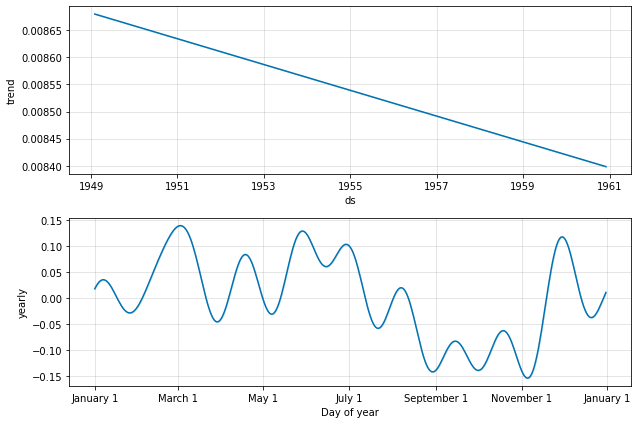

In [55]:
prophet.plot_components(forecast)
plt.show()

#### Error calculation

In [56]:
print(f"RMSE: {mean_squared_error(df_test['Passengers'], forecast_test['yhat'])}")

RMSE: 0.0027616433344446454


### AR model

#### Training

In [57]:
auto_reg_model = AutoReg(df_train, lags=2).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [58]:
print(auto_reg_model.summary())

                            AutoReg Model Results                             
Dep. Variable:             Passengers   No. Observations:                  131
Model:                     AutoReg(2)   Log Likelihood                 110.140
Method:               Conditional MLE   S.D. of innovations              0.103
Date:                Thu, 16 Mar 2023   AIC                           -212.280
Time:                        00:53:37   BIC                           -200.840
Sample:                    04-01-1949   HQIC                          -207.632
                         - 12-01-1959                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0085      0.009      0.932      0.352      -0.009       0.026
Passengers.L1     0.2214      0.087      2.547      0.011       0.051       0.392
Passengers.L2    -0.1739      0.087     

In [59]:
forecasts = auto_reg_model.forecast(FORECAST_SIZE).tolist()

test_values = df_test['Passengers'].tolist()
for index in range(len(forecasts)):
  difference = forecasts[index] - test_values[index]
  print(forecasts[index], test_values[index], difference)

0.05374158679923015 0.029199154692262752 0.024542432106967396
0.0008841590596421513 -0.06437866181343566 0.0652628208730778
-0.0006456313121155337 0.06916335993677158 -0.06980899124888712
0.00820929469790878 0.09552712307451117 -0.08731782837660239
0.010436277194541207 0.023580942588906417 -0.01314466539436521
0.00938926557986455 0.12528776131045127 -0.11589849573058672
0.00877006003153359 0.15067334584317305 -0.14190328581163947
0.008815049306428452 -0.026060106669865135 0.034875155976293586
0.008932712847421862 -0.1763985384908322 0.18533125133825407
0.008950943974786468 -0.0970834045818334 0.10603434855661986
0.008934515541647932 -0.1672513038729564 0.17618581941460432
0.008927706498524349 0.10227884912041851 -0.09335114262189416


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Text(0.5, 1.0, 'Forecast using AutoReg')

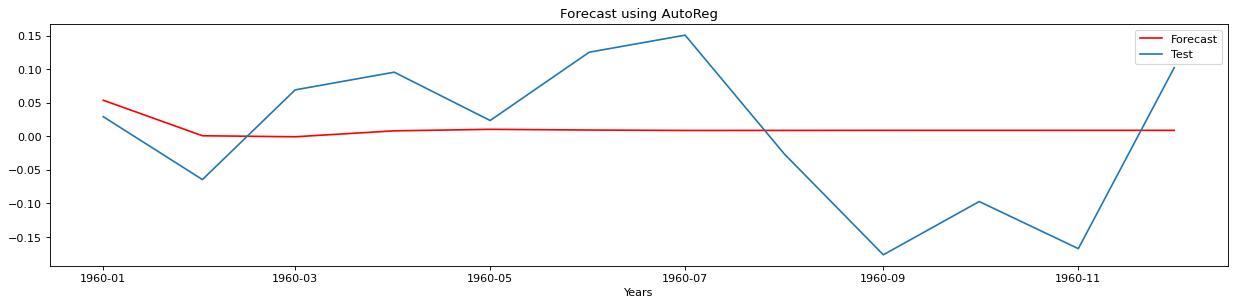

In [60]:
plt.figure(figsize=(19, 4), dpi=80)
plt.plot(df_test.index, forecasts, 'red')
plt.plot(df_test.index, df_test['Passengers'])
plt.legend(["Forecast", "Test"])
plt.xlabel("Years")
plt.title("Forecast using AutoReg")

In [61]:
print(f"RMSE: {mean_squared_error(test_values, forecasts)}")

RMSE: 0.011472013527593456


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Text(0.5, 1.0, 'Forecast using AutoReg')

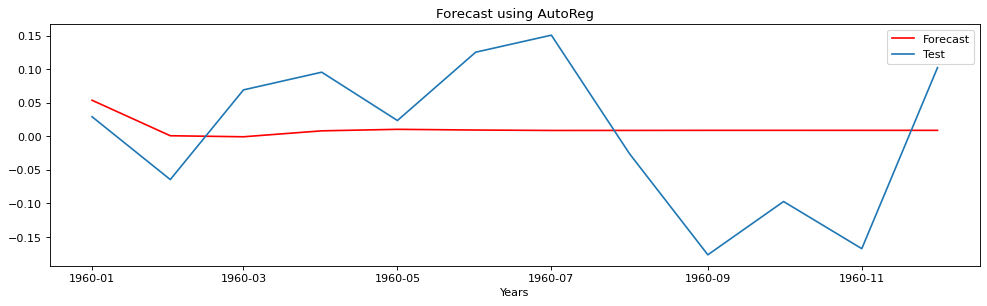

In [62]:
pred = auto_reg_model.predict(start=len(df_train), end=(len(dataset_log)-1), dynamic=False)

plt.figure(figsize=(15, 4), dpi=80)
plt.plot(df_test.index, pred, 'red')
plt.plot(df_test.index, df_test['Passengers'])
plt.legend(["Forecast", "Test"])
plt.xlabel("Years")
plt.title("Forecast using AutoReg")

### ARIMA

In [63]:
p = 2
d = 1
q = 2

arima_model = ARIMA(df_train, order=(p, d, q))
model_result = arima_model.fit()
print(model_result.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 110.927
Date:                Thu, 16 Mar 2023   AIC                           -211.853
Time:                        00:53:40   BIC                           -197.516
Sample:                    02-01-1949   HQIC                          -206.027
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6001      0.166     -3.610      0.000      -0.926      -0.274
ar.L2          0.0321      0.120      0.268      0.789      -0.203       0.267
ma.L1         -0.1196      7.743     -0.015      0.9

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Forecast using AutoReg - Train')

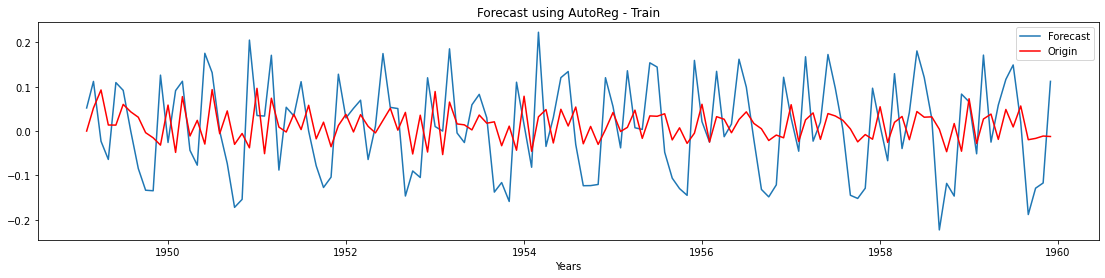

In [64]:
plt.figure(figsize=(19, 4))
plt.plot(df_train.index, df_train['Passengers'])
plt.plot(df_train.index, model_result.fittedvalues, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using AutoReg - Train")

In [65]:
start_date = df_test['Passengers'].head(1).index[0]
end_date   = df_test['Passengers'].tail(1).index[0]

predicted_test = model_result.predict(start=start_date, end=end_date)

In [66]:
predicted_test

1960-01-01    0.053528
1960-02-01   -0.012614
1960-03-01    0.025196
1960-04-01    0.000381
1960-05-01    0.016487
1960-06-01    0.006025
1960-07-01    0.012821
1960-08-01    0.008406
1960-09-01    0.011274
1960-10-01    0.009411
1960-11-01    0.010621
1960-12-01    0.009835
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Forecast test data using ARIMA')

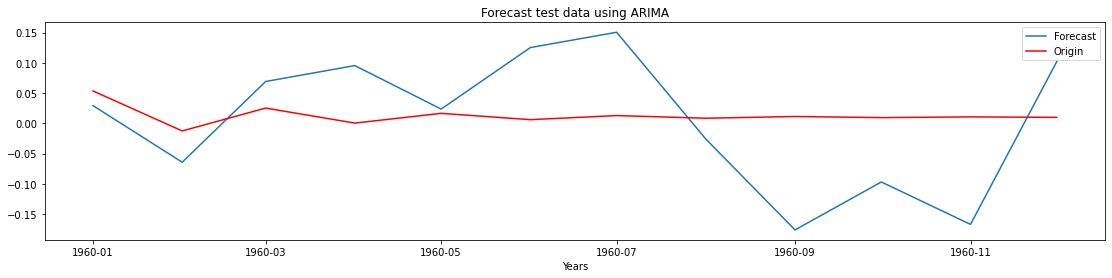

In [67]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['Passengers'])
plt.plot(predicted_test.index, predicted_test, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast test data using ARIMA")

In [68]:
print(f"RMSE: {mean_squared_error(df_test['Passengers'], predicted_test)}")

RMSE: 0.011289081753779287


### Exponential Smoothing

In [69]:
simple_exp_smoothing_model = SimpleExpSmoothing(df_train).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [70]:
simple_exp_smoothing_model.fittedvalues

Month
1949-02-01    0.009812
1949-03-01    0.009812
1949-04-01    0.009812
1949-05-01    0.009812
1949-06-01    0.009812
                ...   
1959-08-01    0.009812
1959-09-01    0.009812
1959-10-01    0.009812
1959-11-01    0.009812
1959-12-01    0.009812
Length: 131, dtype: float64

Text(0.5, 1.0, 'Forecast using AutoReg - Train')

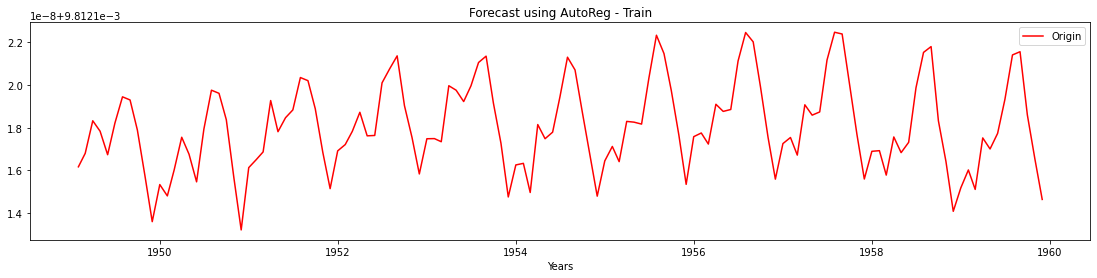

In [71]:
plt.figure(figsize=(19, 4))
# plt.plot(df_train.index, df_train['Passengers'])
plt.plot(df_train.index, simple_exp_smoothing_model.fittedvalues, 'red')
plt.legend(["Origin", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast using AutoReg - Train")

Text(0.5, 1.0, 'Forecast using AutoReg - Train')

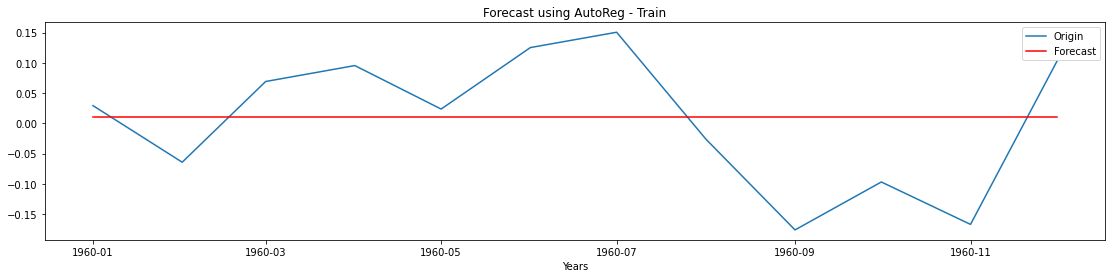

In [72]:
start_date = df_test['Passengers'].head(1).index[0]
end_date   = df_test['Passengers'].tail(1).index[0]

forecast_test = simple_exp_smoothing_model.predict(start=start_date, end=end_date)

plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['Passengers'])
plt.plot(forecast_test.index, forecast_test, 'red')
plt.legend(["Origin", "Forecast"])
plt.xlabel("Years")
plt.title("Forecast using AutoReg - Train")

In [73]:
forecast_test

1960-01-01    0.009812
1960-02-01    0.009812
1960-03-01    0.009812
1960-04-01    0.009812
1960-05-01    0.009812
1960-06-01    0.009812
1960-07-01    0.009812
1960-08-01    0.009812
1960-09-01    0.009812
1960-10-01    0.009812
1960-11-01    0.009812
1960-12-01    0.009812
Freq: MS, dtype: float64

In [74]:
print(f"RMSE: {mean_squared_error(df_test['Passengers'], forecast_test)}")

RMSE: 0.01145044005246315
